In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv('/content/personal_finance_management.csv')
df.head()

,Date,Time,Mode,Category,Subcategory,Type,Amount,Description
0,2022-08-14,07:16:00,Credit Card,Food,Coffee,Expense,1576.15,Leave brother bank better she increase try.
1,2023-06-16,03:36:22,Credit Card,Transport,Train,Expense,1923.33,Stand next though house.
2,2022-11-26,00:40:03,Credit Card,Entertainment,Subscription,Expense,987.08,Detail subject everything goal yes blue tonight.
3,2023-10-25,12:13:24,Cash,Shopping,Clothes,Expense,1262.74,Represent since method left plant.
4,2023-02-05,02:51:27,Debit Card,Income,Freelance,Income,4300.48,Budget situation between.


## Understanding the Data

In [ ]:
df.shape

(5000, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         5000 non-null   object 
 1   Time         5000 non-null   object 
 2   Mode         5000 non-null   object 
 3   Category     5000 non-null   object 
 4   Subcategory  5000 non-null   object 
 5   Type         5000 non-null   object 
 6   Amount       5000 non-null   float64
 7   Description  5000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 312.6+ KB


In [ ]:
df.isnull().sum()

Date           0
Time           0
Mode           0
Category       0
Subcategory    0
Type           0
Amount         0
Description    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.describe(include='all')

,Date,Time,Mode,Category,Subcategory,Type,Amount,Description
count,5000,5000,5000,5000,5000,5000,5000.000000,5000
unique,729,4866,4,7,22,2,NaN,5000
top,2023-08-07,07:41:44,Cash,Utilities,Gym,Expense,NaN,Leave brother bank better she increase try.
freq,19,3,1281,753,273,4331,NaN,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,1241.565154,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,919.951670,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,5.140000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,586.792500,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,1129.645000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,1655.800000,NaN


## Converting Data Types:

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time']).dt.time
df['Category'] = df['Category'].astype('category')
df['Subcategory'] = df['Subcategory'].astype('category')
df['Type'] = df['Type'].astype('category')
df['Mode'] = df['Mode'].astype('category')

In [ ]:
df.dtypes

Date           datetime64[ns]
Time                   object
Mode                 category
Category             category
Subcategory          category
Type                 category
Amount                float64
Description            object
dtype: object

# Exploratory Data Analysis (EDA)

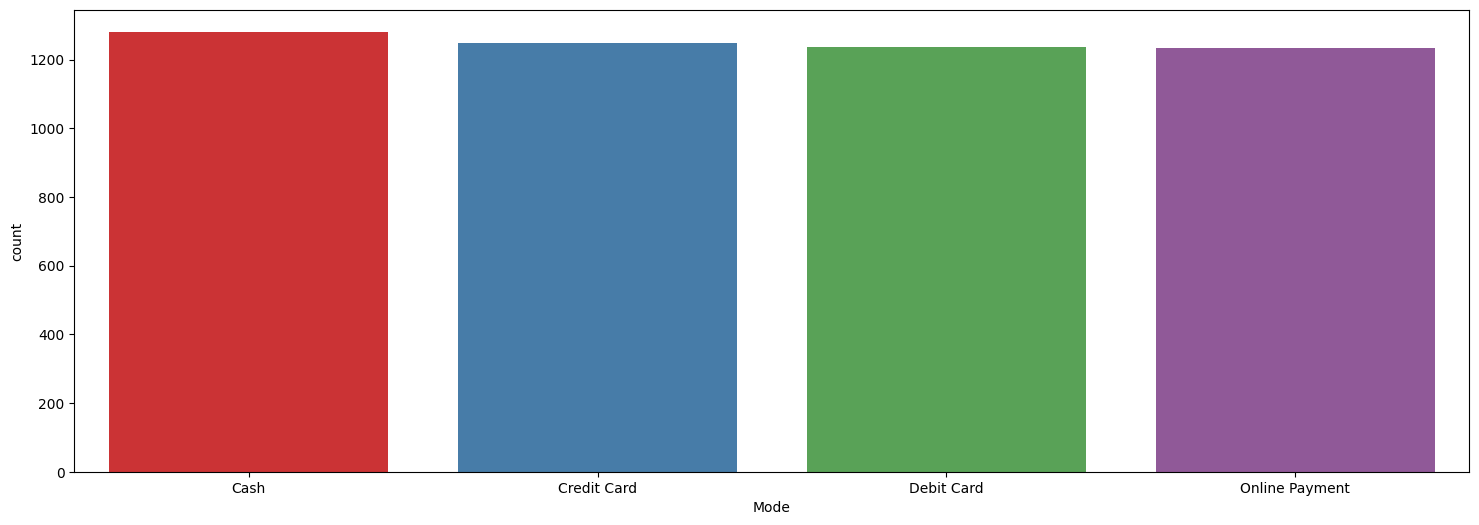

In [ ]:
plt.figure(figsize=(18,6))
sns.countplot(x='Mode',data=df, order=df['Mode'].value_counts().index, palette='Set1')
plt.show()

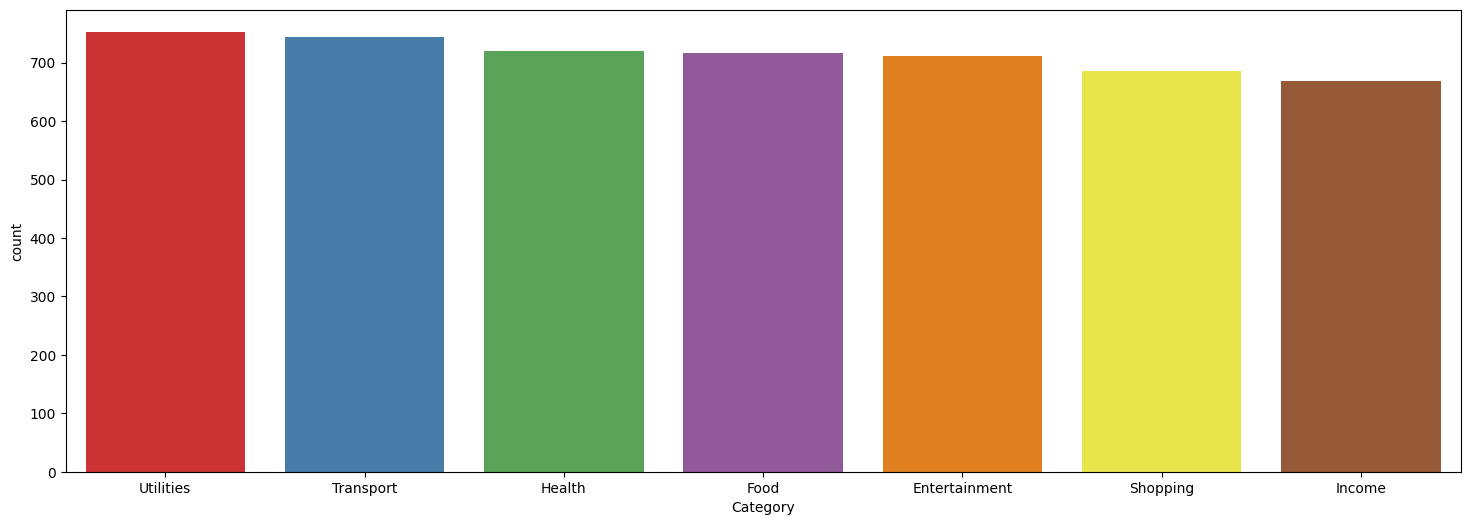

In [ ]:
plt.figure(figsize=(18,6))
sns.countplot(x='Category',data=df, order=df['Category'].value_counts().index, palette='Set1')
plt.show()

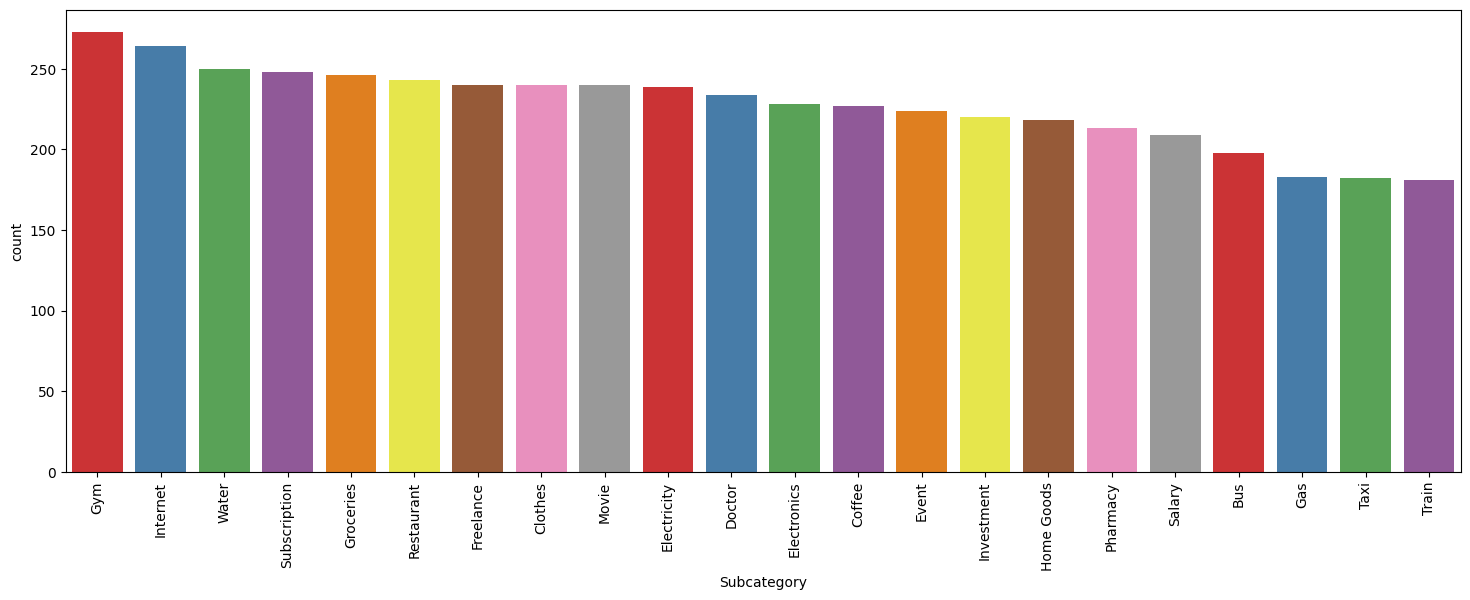

In [ ]:
plt.figure(figsize=(18,6))
sns.countplot(x='Subcategory',data=df, order=df['Subcategory'].value_counts().index, palette='Set1')
plt.xticks(rotation=90)
plt.show()

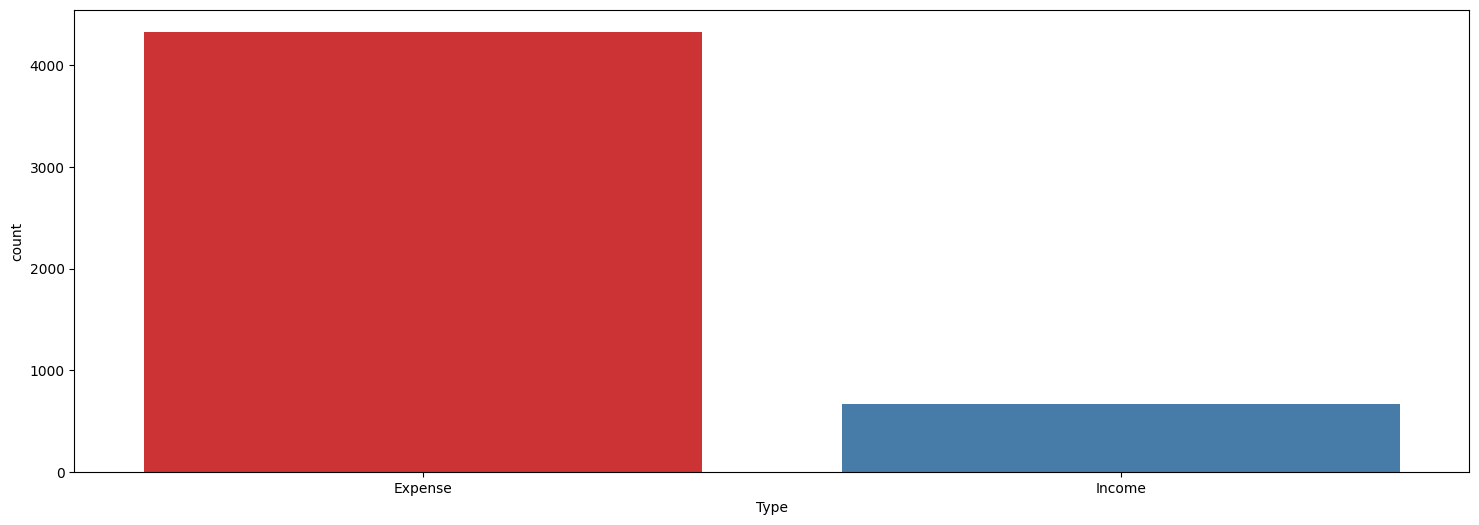

In [ ]:
plt.figure(figsize=(18,6))
sns.countplot(x='Type',data=df, order=df['Type'].value_counts().index, palette='Set1')
plt.show()

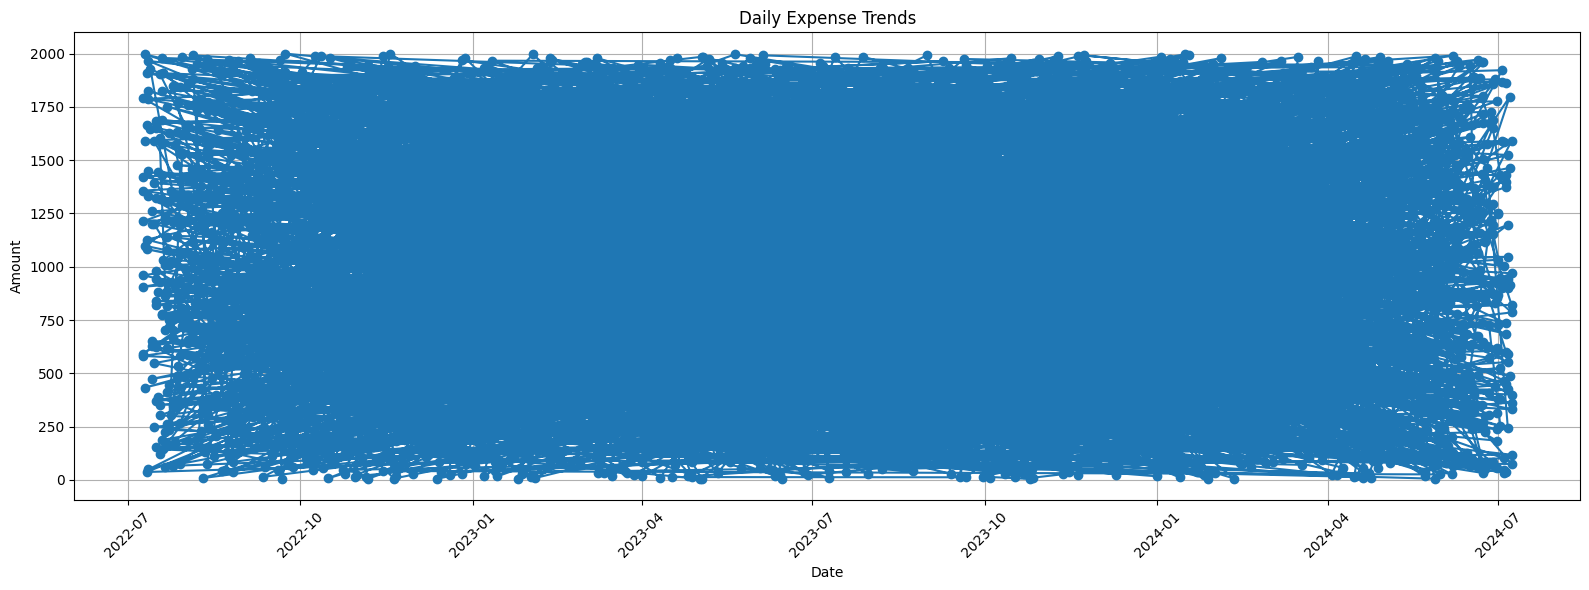

In [ ]:
expenses = df[df['Type'] == 'Expense']

# Plot daily expenses trends
plt.figure(figsize=(16, 6))
plt.plot(expenses['Date'], expenses['Amount'], marker='o', linestyle='-')
plt.title('Daily Expense Trends')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

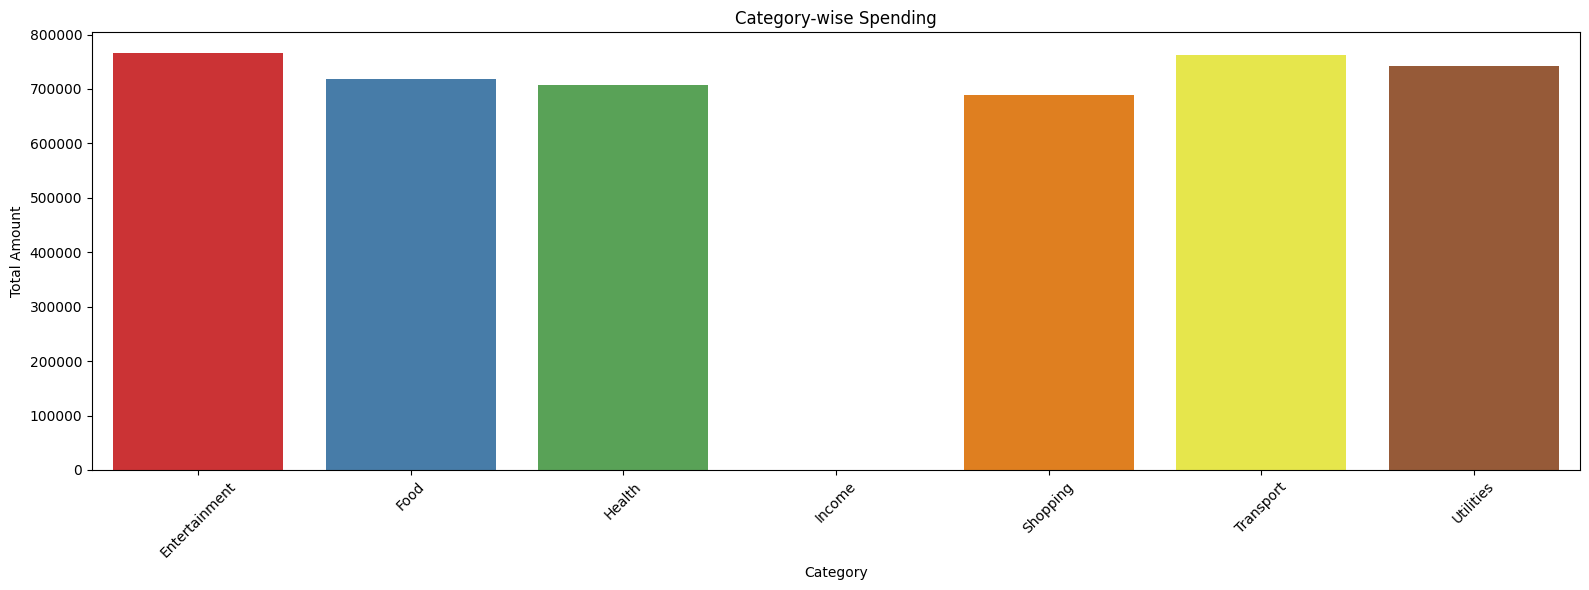

In [ ]:
# Ensure that 'expenses' includes only expense transactions
expenses = df[df['Type'] == 'Expense']

# Group by category and sum the expenses
category_expenses = expenses.groupby('Category')['Amount'].sum().reset_index()

# Plot category-wise spending
plt.figure(figsize=(16, 6))
sns.barplot(data=category_expenses, x='Category', y='Amount', palette='Set1')
plt.title('Category-wise Spending')
plt.xlabel('Category')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


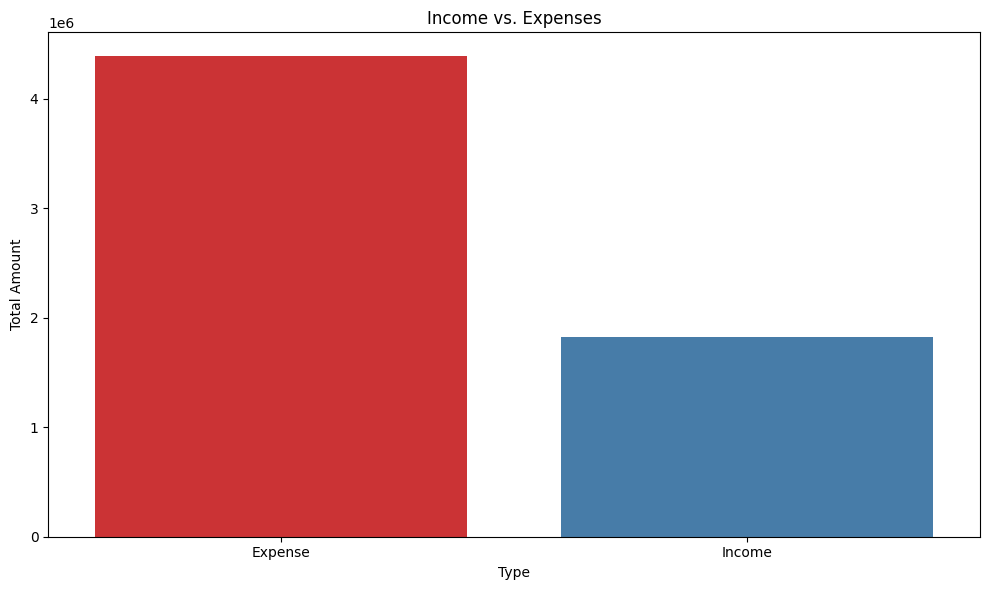

In [ ]:
# Group by type (Income/Expense) and sum the amounts
income_expenses = df.groupby('Type')['Amount'].sum().reset_index()

# Plot income vs expenses
plt.figure(figsize=(10, 6))
sns.barplot(data=income_expenses, x='Type', y='Amount',palette='Set1')
plt.title('Income vs. Expenses')
plt.xlabel('Type')
plt.ylabel('Total Amount')
plt.tight_layout()
plt.show()


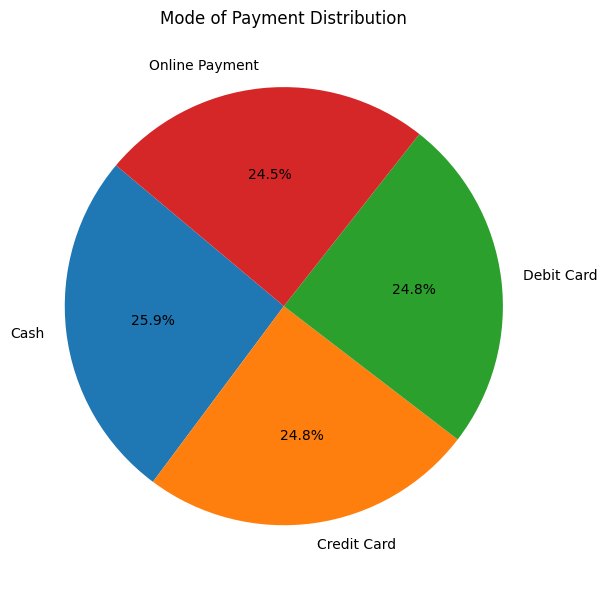

In [ ]:
# Group by mode and sum the expenses
mode_expenses = expenses.groupby('Mode')['Amount'].sum().reset_index()

# Plot mode of payment distribution
plt.figure(figsize=(8, 6))
plt.pie(mode_expenses['Amount'], labels=mode_expenses['Mode'], autopct='%1.1f%%', startangle=140)
plt.title('Mode of Payment Distribution')
plt.tight_layout()
plt.show()


# Feature Engineering

In [ ]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'] >= 5

In [ ]:
df.head()

,Date,Time,Mode,Category,Subcategory,Type,Amount,Description,Year,Month,Day,DayOfWeek,IsWeekend
0,2022-08-14,07:16:00,Credit Card,Food,Coffee,Expense,1576.15,Leave brother bank better she increase try.,2022,8,14,6,True
1,2023-06-16,03:36:22,Credit Card,Transport,Train,Expense,1923.33,Stand next though house.,2023,6,16,4,False
2,2022-11-26,00:40:03,Credit Card,Entertainment,Subscription,Expense,987.08,Detail subject everything goal yes blue tonight.,2022,11,26,5,True
3,2023-10-25,12:13:24,Cash,Shopping,Clothes,Expense,1262.74,Represent since method left plant.,2023,10,25,2,False
4,2023-02-05,02:51:27,Debit Card,Income,Freelance,Income,4300.48,Budget situation between.,2023,2,5,6,True


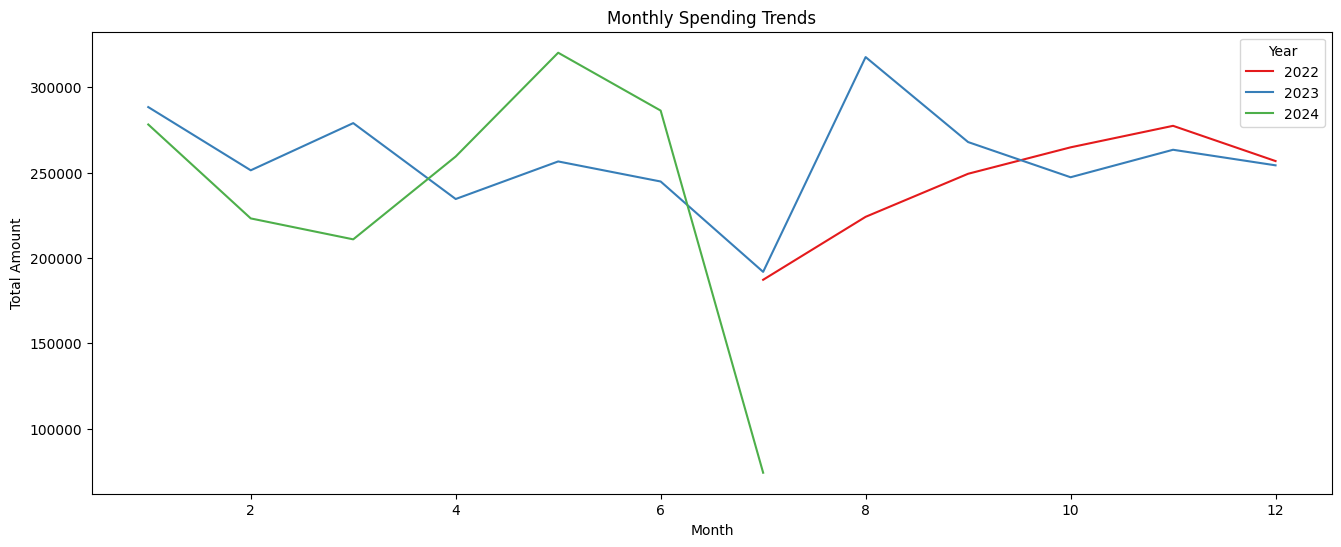

In [ ]:
# Group by Year and Month to analyze monthly trends
monthly_trends = df.groupby(['Year', 'Month'])['Amount'].sum().reset_index()

# Plot monthly trends
plt.figure(figsize=(16, 6))
sns.lineplot(data=monthly_trends, x='Month', y='Amount', hue='Year', palette='Set1')
plt.title('Monthly Spending Trends')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.show()


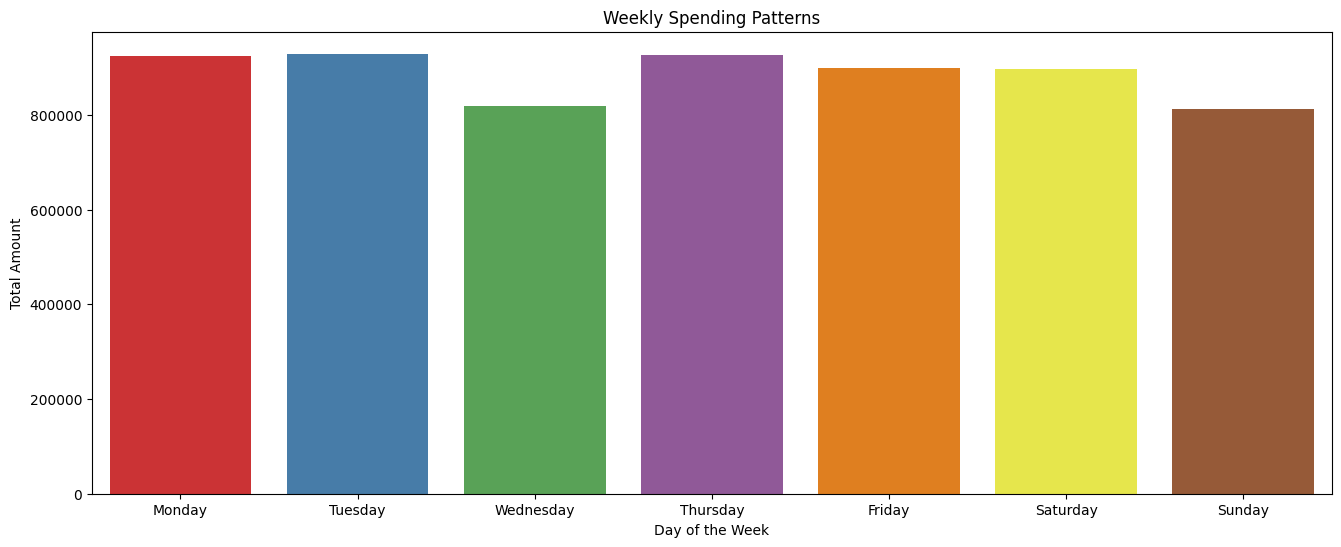

In [ ]:
# Group by DayOfWeek to analyze weekly patterns
weekly_trends = df.groupby('DayOfWeek')['Amount'].sum().reset_index()

# Map DayOfWeek numbers to names
days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
weekly_trends['DayOfWeek'] = weekly_trends['DayOfWeek'].map(days)

# Plot weekly spending patterns
plt.figure(figsize=(16, 6))
sns.barplot(data=weekly_trends, x='DayOfWeek', y='Amount', palette='Set1')
plt.title('Weekly Spending Patterns')
plt.xlabel('Day of the Week')
plt.ylabel('Total Amount')
plt.show()


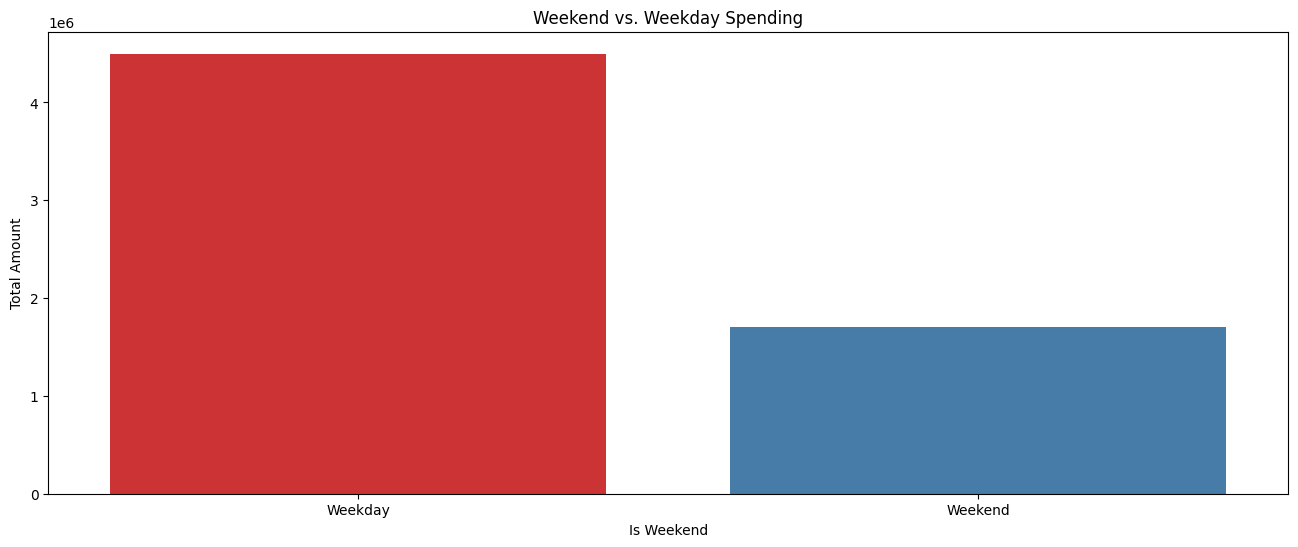

In [ ]:
# Group by IsWeekend to compare weekend and weekday spending
weekend_trends = df.groupby('IsWeekend')['Amount'].sum().reset_index()

# Plot weekend vs weekday spending
plt.figure(figsize=(16, 6))
sns.barplot(data=weekend_trends, x='IsWeekend', y='Amount', palette='Set1')
plt.title('Weekend vs. Weekday Spending')
plt.xlabel('Is Weekend')
plt.ylabel('Total Amount')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()

# outliers

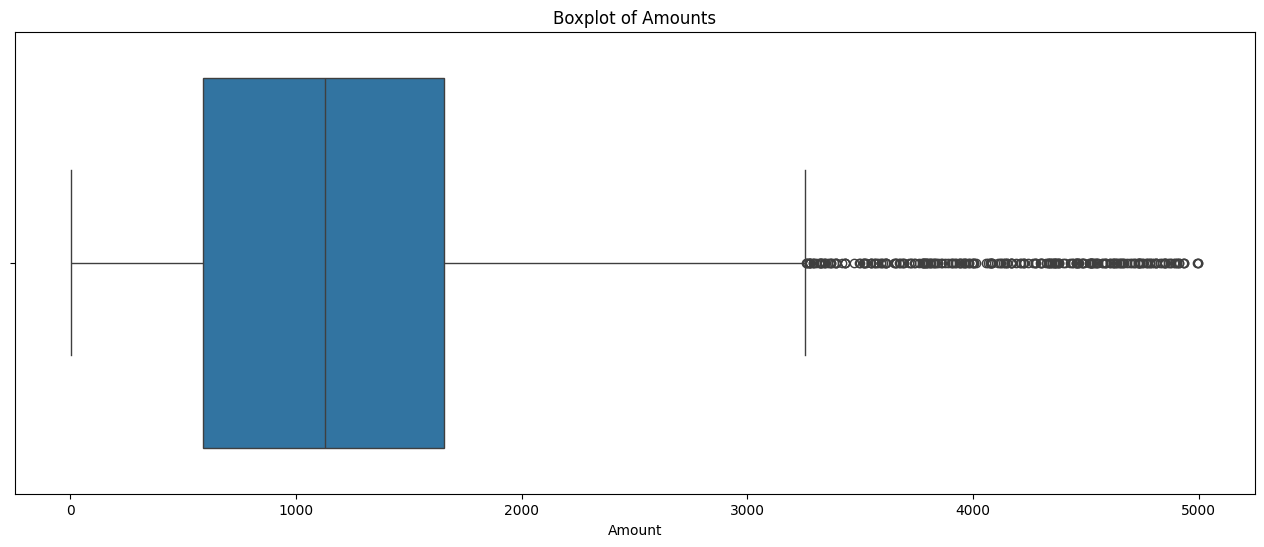

In [ ]:
# Visualize outliers with a boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(x='Amount',data=df)
plt.title('Boxplot of Amounts')
plt.show()

In [ ]:
q1 = df['Amount'].quantile(0.25)
q3 = df['Amount'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [ ]:
# Identify outliers
outliers = df[(df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)]

In [ ]:
outliers.shape

(256, 13)

In [ ]:
df['Amount'] = np.where(df['Amount']>upper_bound,upper_bound,df['Amount'])

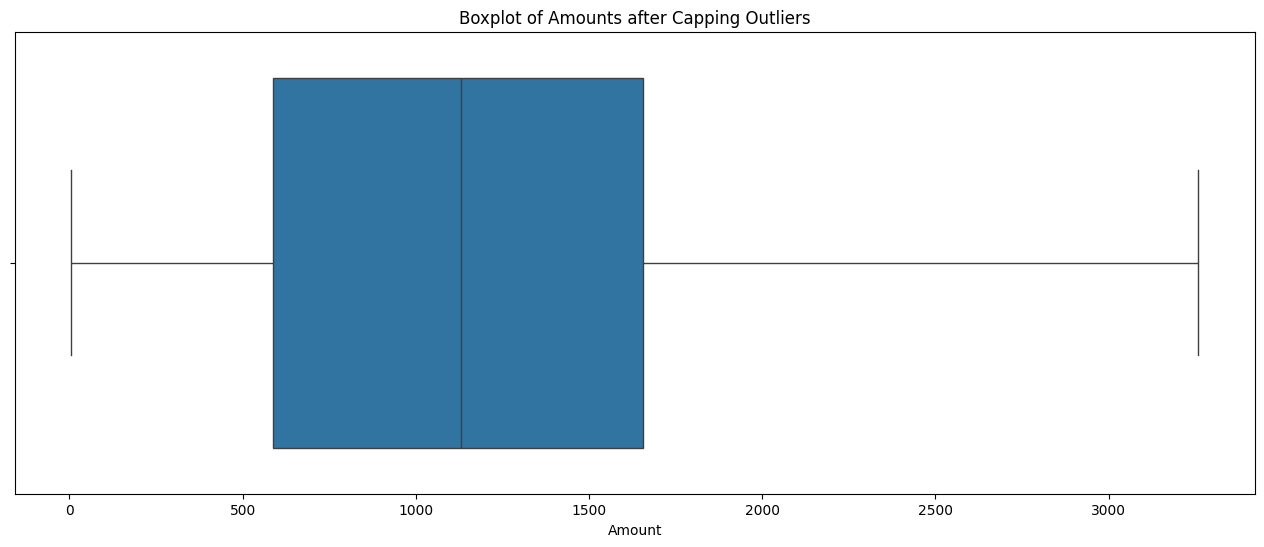

In [ ]:
plt.figure(figsize=(16, 6))
sns.boxplot(x=df['Amount'])
plt.title('Boxplot of Amounts after Capping Outliers')
plt.show()

In [ ]:
df.isnull().sum()

Date           0
Time           0
Mode           0
Category       0
Subcategory    0
Type           0
Amount         0
Description    0
Year           0
Month          0
Day            0
DayOfWeek      0
IsWeekend      0
dtype: int64

# Scaling the Amount

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])

# Time Series Preparation

In [ ]:
# Sort data by Date
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)

In [ ]:
df.head(5)

,Time,Mode,Category,Subcategory,Type,Amount,Description,Year,Month,Day,DayOfWeek,IsWeekend,Amount_scaled
Date,,,,,,,,,,,,,
2022-07-09,05:49:22,Cash,Income,Salary,Income,1891.63,Care kitchen purpose difference.,2022,7,9,5,True,0.887528
2022-07-09,04:39:06,Debit Card,Utilities,Electricity,Expense,1357.33,Other follow stand view specific room senior.,2022,7,9,5,True,0.204853
2022-07-09,04:05:03,Debit Card,Health,Gym,Expense,1212.73,Including music girl eight.,2022,7,9,5,True,0.020097
2022-07-09,06:09:46,Cash,Transport,Taxi,Expense,591.90,Much wish force.,2022,7,9,5,True,-0.773137
2022-07-09,23:24:59,Credit Card,Entertainment,Event,Expense,906.19,Usually high my somebody item college.,2022,7,9,5,True,-0.371569


# Split the Data into Training and Testing Sets

In [ ]:
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
train.shape

(4000, 13)

In [ ]:
test.shape

(1000, 13)

# Build and Train the Model

In [ ]:
# Fit the ARIMA model
#model = ARIMA(train['Amount_scaled'], order=(5, 1, 0))
#model_fit = model.fit()

In [ ]:
# Make predictions
#predictions = model_fit.forecast(steps=len(test))


In [ ]:
# Add predictions to the test set
#test['Predictions'] = predictions.values

In [ ]:
# Calculate RMSE
#rmse = np.sqrt(mean_squared_error(test['Amount_scaled'], test['Predictions']))
#print(f'RMSE: {rmse}')

In [ ]:
# Plot the results
#plt.figure(figsize=(16, 6))
#plt.plot(train['Amount_scaled'], label='Training Data')
#plt.plot(test['Amount_scaled'], label='Test Data')
#plt.plot(test.index, test['Predictions'], label='Predictions', color='red')
#plt.legend()
#plt.show()

In [ ]:
# Fit the Exponential Smoothing model
model = ExponentialSmoothing(train['Amount_scaled'], trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

In [ ]:
# Make predictions
predictions = model_fit.forecast(steps=len(test))

In [ ]:
# Add predictions to the test set
test['Predictions'] = predictions.values

In [ ]:
predictions.isnull().sum()

0

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Amount_scaled'], test['Predictions']))
print(f'RMSE: {rmse}')

RMSE: 1.0243842399964995


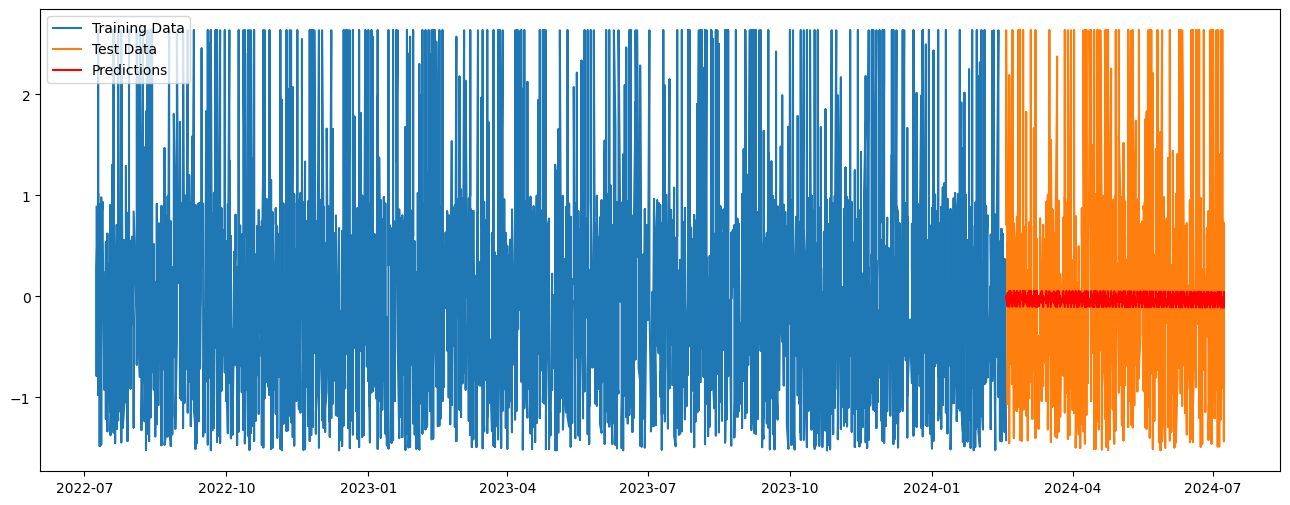

In [ ]:
# Plot the results
plt.figure(figsize=(16, 6))
plt.plot(train['Amount_scaled'], label='Training Data')
plt.plot(test['Amount_scaled'], label='Test Data')
plt.plot(test.index, test['Predictions'], label='Predictions', color='red')
plt.legend()
plt.show()